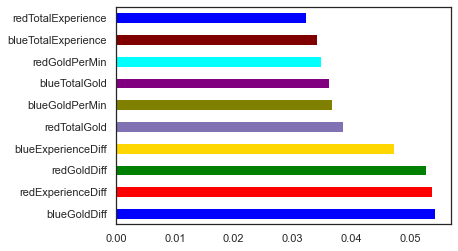

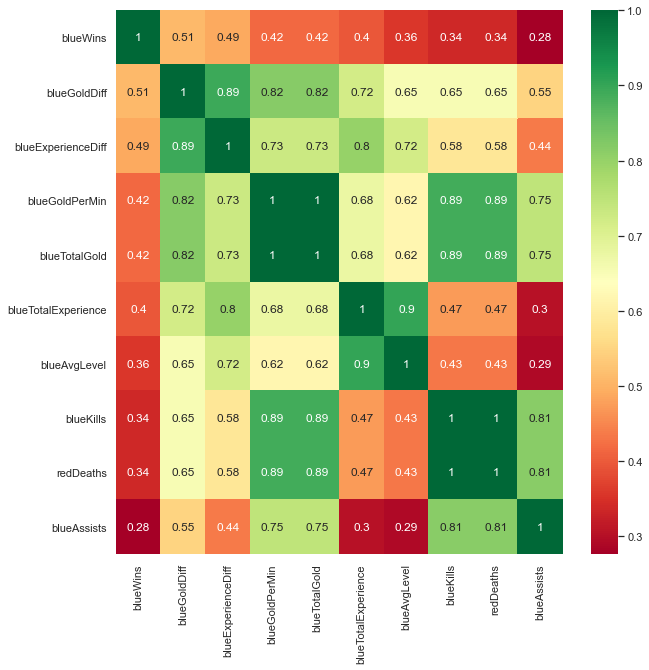

In [26]:
from Data_visualization.Feature_selection import FeatImp
from Data_cleanup.Cleanup import BlueRedSubstraction,Normalisation
from data_collect import detect_outliers
from Training.Training import cross_val_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



data = pd.read_csv('data/lol.csv') 
features = FeatImp(data)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")


sns.set(style='white', context='notebook', palette='deep')

'Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"\nfeaturov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare\ndil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'

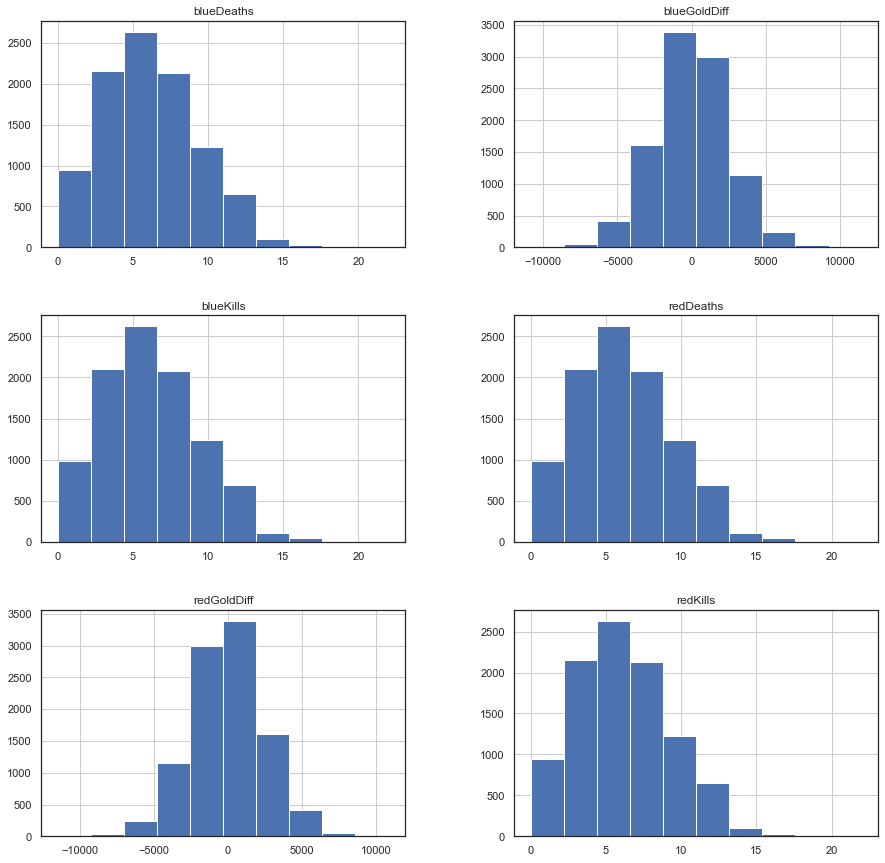

In [4]:
data[['blueKills',
 'redDeaths','redKills','blueDeaths',"blueGoldDiff",'redGoldDiff']].hist(figsize = (15,15))
data_0 = data.drop(['gameId'],axis = 1)
'''Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"
featurov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare
dil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'''

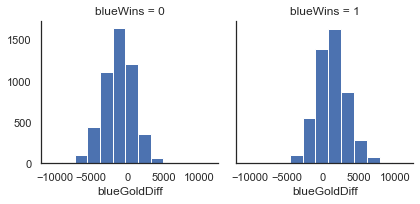

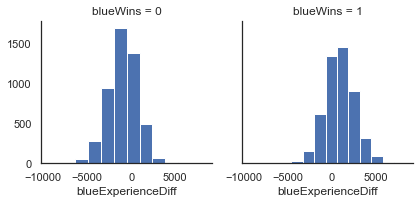

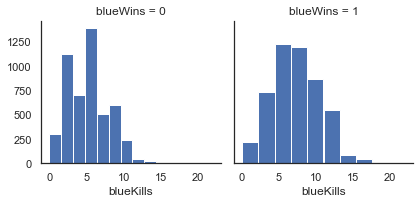

In [13]:
g = sns.FacetGrid(data_0, col='blueWins')
g = g.map(plt.hist,"blueGoldDiff")
g2 = sns.FacetGrid(data_0, col='blueWins')
g2 = g2.map(plt.hist,"blueExperienceDiff")
g3 = sns.FacetGrid(data_0, col='blueWins')
g2 = g3.map(plt.hist,"blueKills")

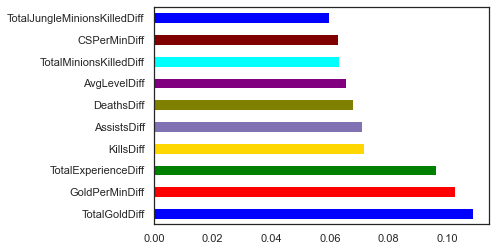

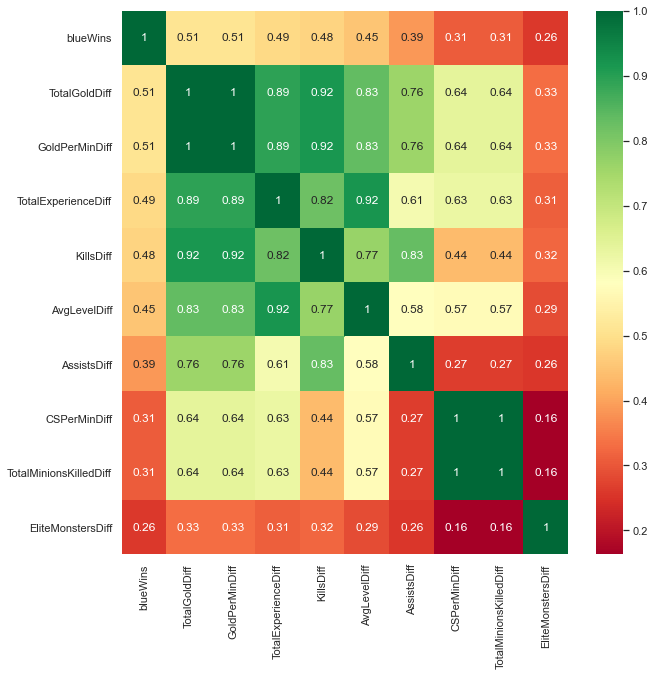

In [36]:
target = data['blueWins']
data_1 = BlueRedSubstraction(data) #spremenjeni podatki
data_2 = pd.concat([data_1,target],axis = 1)
features = FeatImp(data_2)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")
''' Opazim, da imata TotalGold ter GoldPerMin cisto iste korelacije, zato sem šel pogledat vrednosti stolpcev, ter ugotovil da se razlikujeta le
v enem faktorju. Mislim, da se lahko znebim featura GoldPerMin. Enako velja za CSPerMin.'''
data_3 = data_2.drop(["GoldPerMinDiff","blueWins","CSPerMinDiff"],axis = 1) # ovržem nekatere podobne stolpce,ter target stolpec


In [44]:
train_len = int(data_3.shape[0]*0.8)
train = data_3[:train_len]
test = data_3[train_len:]

target_train = target[:train_len]
target_test = target[train_len:]

,CrossValMeans,CrossValerrors,Algorithm
0,0.724783,0.010479,SVC
1,0.629119,0.011392,AdaBoost
2,0.717815,0.010731,RandomForest
3,0.709070,0.016983,ExtraTrees
4,0.680183,0.016140,KNeighboors
5,0.733780,0.013649,LogisticRegression


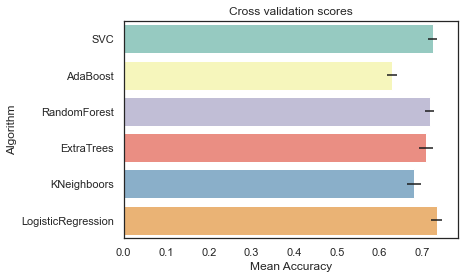

In [45]:
norm = Normalisation(MM = True)
train_sc, train_mm = norm.transform(X = train)
#data_sc standardna normalizacija
#data_mm  Min-Max normalizacija
outliers = detect_outliers(train_sc,6,train_sc.columns.values)
train_sc1 = train_sc.drop(outliers,axis = 0)
target_train1 = target_train.drop(outliers,axis = 0)
cv_results = cross_val_results(train_sc1,target_train1)
cv_results